# Fake News Detection menggunakan PySpark dan MLlib

Nama   : Revo Fallentino  
NIM    : 22.11.5095  
Prodi  : Informatika  
Universitas AMIKOM Yogyakarta  
Dataset : Fake and Real News Dataset (Kaggle)


## 1. Inisialisasi Spark

Tahap ini digunakan untuk membangun SparkSession sebagai dasar
pemrosesan data Big Data menggunakan Apache Spark.


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FakeNewsBigData") \
    .getOrCreate()

spark


## 2. Load Dataset

Dataset Fake News dibaca dari file CSV menggunakan PySpark DataFrame.


In [4]:
from pyspark.sql.functions import lit

fake = spark.read.csv(
    "Fake.csv", header=True, inferSchema=True
).withColumn("label", lit(0))

real = spark.read.csv(
    "True.csv", header=True, inferSchema=True
).withColumn("label", lit(1))

df = fake.union(real)
df.show(5)


+--------------------+--------------------+-------+-----------------+-----+
|               title|                text|subject|             date|label|
+--------------------+--------------------+-------+-----------------+-----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|    0|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|    0|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|    0|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|    0|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|    0|
+--------------------+--------------------+-------+-----------------+-----+
only showing top 5 rows


## 3. MapReduce (RDD)

Pemrosesan batch menggunakan konsep MapReduce untuk
menghitung distribusi label berita.


In [5]:
rdd = df.select("label").rdd

mapped = rdd.map(lambda x: (x[0], 1))
reduced = mapped.reduceByKey(lambda a, b: a + b)

reduced.collect()


[(0, 8108), (1, 10184)]

## 4. Exploratory Data Analysis (EDA)

EDA dilakukan untuk melihat distribusi data fake dan real news.


In [6]:
df.printSchema()
df.groupBy("label").count().show()


root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: integer (nullable = false)

+-----+-----+
|label|count|
+-----+-----+
|    0| 8108|
|    1|10184|
+-----+-----+



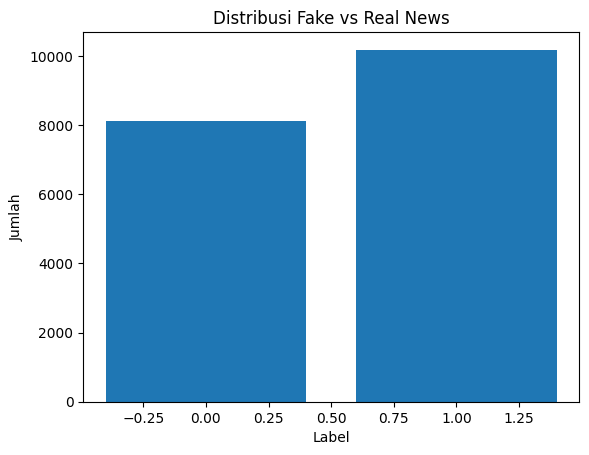

In [7]:
import matplotlib.pyplot as plt

label_count = df.groupBy("label").count().toPandas()

plt.bar(label_count['label'], label_count['count'])
plt.title("Distribusi Fake vs Real News")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()


In [9]:
df = df.dropna(subset=["text"])


## 5. Preprocessing Data

Tahap preprocessing meliputi tokenisasi dan penghapusan stopwords
agar data teks siap digunakan untuk pemodelan.


In [10]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df = remover.transform(df)

df.select("filtered").show(3, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
df.createOrReplaceTempView("news")

spark.sql("""
SELECT label, COUNT(*) AS total
FROM news
GROUP BY label
""").show()


+-----+-----+
|label|total|
+-----+-----+
|    0| 8100|
|    1|10184|
+-----+-----+



In [12]:
text_rdd = df.select("label", "filtered").rdd

flatmapped = text_rdd.flatMap(lambda x: [(word, 1) for word in x[1]])
word_count = flatmapped.reduceByKey(lambda a,b: a+b)

word_count.take(10)


[('new', 13631),
 ('give', 2325),
 ('', 118942),
 ('fake', 1056),
 ('media.', 338),
 ('reality', 884),
 ('show', 2753),
 ('star', 808),
 ('grows', 32),
 ('haters,', 13)]

## 6. Feature Extraction

Ekstraksi fitur dilakukan menggunakan TF-IDF untuk mengubah teks
menjadi representasi numerik.


In [13]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)


In [14]:
train, test = df.randomSplit([0.8, 0.2], seed=42)


## 7. Pemodelan Machine Learning

Model klasifikasi digunakan untuk membedakan berita palsu dan asli.


In [15]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train)

lr_pred = lr_model.transform(test)


In [16]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features", labelCol="label")
nb_model = nb.fit(train)

nb_pred = nb_model.transform(test)


## 8. Evaluasi Model

Evaluasi dilakukan menggunakan accuracy, precision, recall, dan F1-score.


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

lr_acc = evaluator.evaluate(lr_pred)
nb_acc = evaluator.evaluate(nb_pred)

lr_acc, nb_acc


(0.9892715979672502, 0.9672501411631846)

In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .build()

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train)
best_model = cv_model.bestModel


In [19]:
final_pred = best_model.transform(test)
final_acc = evaluator.evaluate(final_pred)

final_acc


0.9949181253529079

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [21]:
accuracy_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = accuracy_eval.evaluate(final_pred)
accuracy


0.9949181253529079

In [22]:
precision_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

precision = precision_eval.evaluate(final_pred)
precision


0.9949256520680654

In [23]:
recall_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

recall = recall_eval.evaluate(final_pred)
recall


0.9949181253529079

In [24]:
f1_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = f1_eval.evaluate(final_pred)
f1_score


0.9949167381558908

In [25]:
auc_eval = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = auc_eval.evaluate(final_pred)
auc


0.9993725740175198

In [26]:
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-Score :", f1_score)
print("AUC      :", auc)


Accuracy : 0.9949181253529079
Precision: 0.9949256520680654
Recall   : 0.9949181253529079
F1-Score : 0.9949167381558908
AUC      : 0.9993725740175198


## 9. Kesimpulan

Model yang dibangun mampu mengklasifikasikan berita palsu dan berita asli
dengan performa yang baik menggunakan pendekatan Big Data.
